<a href="https://colab.research.google.com/github/paras9o9/Suicidal-Ideation-Detection-using-Machine-Learning/blob/main/notebooks/SID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install kaggle nltk spacy textblob

!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import nltk
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_fscore_support, roc_auc_score,
                             average_precision_score, precision_recall_curve,
                             recall_score)
from sklearn.model_selection import GridSearchCV
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('onw-1.4')

nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 121.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Error loading onw-1.4: Package 'onw-1.4' not found in
[nltk_data]     index


In [2]:
!pip install kaggle

from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list --max-size 100

Saving kaggle.json to kaggle.json
ref                                                            title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
viniciusqroz/ethereum-historical-data                          Ethereum Historical Data                               55987540  2025-09-12 01:04:21.137000            200          9  1.0              
jerzyszocik/ufc-fight-forecast-complete-gold-modeling-dataset  UFC Data: Stats & Rankings & Betting Odds              57927462  2025-09-10 23:28:22.770000            181          9  0.9411765        
cdeotte/modernbert-large-cv938                                 ModernBERT-Large-CV938                                        0  2025-07-17 17:51:11.837000            

In [3]:
!kaggle datasets download -d nikhileswarkomati/suicide-watch

!unzip suicide-watch.zip

df = pd.read_csv('Suicide_Detection.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset URL: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch
License(s): CC-BY-SA-4.0
  0% 0.00/60.6M [00:00<?, ?B/s]
100% 60.6M/60.6M [00:00<00:00, 994MB/s]
Archive:  suicide-watch.zip
  inflating: Suicide_Detection.csv   
Dataset shape: (232074, 3)
Columns: ['Unnamed: 0', 'text', 'class']


DATA EXPLORATION
Dataset shape: (232074, 3)
Columns: ['Unnamed: 0', 'text', 'class']
Memory usage: 227.76 MB

Missing values:
Unnamed: 0    0
text          0
class         0
dtype: int64

Class distribution:
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64
Class balance: class
suicide        0.5
non-suicide    0.5
Name: proportion, dtype: float64

Text length statistics:
count    232074.000000
mean        689.639736
std        1156.334007
min           3.000000
25%         138.000000
50%         315.000000
75%         801.000000
max       40297.000000
Name: text_length, dtype: float64


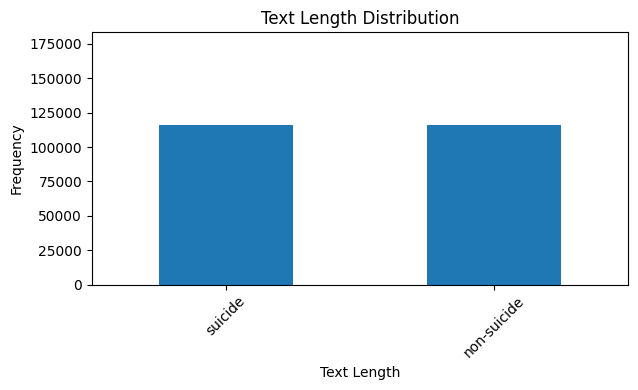

In [4]:
def explore_dataset(df):
    print("="*50)
    print("DATA EXPLORATION")
    print("="*50)

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    print(f"\nMissing values:")
    print(df.isnull().sum())

    if 'class' in df.columns:
        print(f"\nClass distribution:")
        print(df['class'].value_counts())
        print(f"Class balance: {df['class'].value_counts(normalize=True)}")

    if 'text' in df.columns:
        df['text_length'] = df['text'].str.len()
        print(f"\nText length statistics:")
        print(df['text_length'].describe())

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        df['class'].value_counts().plot(kind='bar')
        plt.title('Class Distribution')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 1)
        plt.hist(df['text_length'], bins=50, alpha=0.7)
        plt.title('Text Length Distribution')
        plt.xlabel('Text Length')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

explore_dataset(df)

In [5]:
def analyse_length_distribution(df):
# Uses pd.cut() to bucket texts into categories based on text_length.
    df['length_category'] = pd.cut(df['text_length'],
                                   bins=[0, 100, 500, 1500, float('inf')],
                                   labels=['Very Short', 'Short', 'Medium', 'Long'])
# Groups by class and the new length_category.
    print("Length distribution by cetegory:")
    length_dist = df.groupby(['class', 'length_category']).size().unstack(fill_value=0)
    print(length_dist)
# Looks at percetniles of text length distribution.
    percentiles = [50, 75, 90, 95, 99]
    print(f"Length percentiles:")
    for p in percentiles:
        length = df['text_length'].quantile(p/100)
        print(f"{p}th percentile: {length:.0f} characters")

    return df

df = analyse_length_distribution(df)

Length distribution by cetegory:
length_category  Very Short  Short  Medium   Long
class                                            
non-suicide           29632  69271   13995   3139
suicide                6266  40442   45547  23782
Length percentiles:
50th percentile: 315 characters
75th percentile: 801 characters
90th percentile: 1653 characters
95th percentile: 2457 characters
99th percentile: 5062 characters


/tmp/ipython-input-1285183694.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_dist = df.groupby(['class', 'length_category']).size().unstack(fill_value=0)


In [6]:
# A config dictionary that holds parameters for proprocessing.
PREPROCESSING_CONFIG = {
    'min_length': 10,
    'max_length': 2000,
    'target_length': 512,
    'remove_duplicates': True,
    'handle_class_balance': False
}

def enhanched_preprocessing(df, config=PREPROCESSING_CONFIG):
    print("="*50)
    print("DATA PREPROCESSING")
    print("="*50)

# Keeps track of the original datasets size for retention comparison later.
    initial_count = len(df)
# Drops rows where text_length < 10
    df_clean = df[df['text_length'] >= config['min_length']].copy()
    print(f"After min length filter ({config['min_length']}):{len(df_clean)} samples")
# Finds texts longer than 2000 characters, truncates them to first 2000 characters instead of dropping them.
    long_texts = df_clean['text_length'] > config['max_length']
    print(f"Texts > {config['max_length']} chars: {long_texts.sum()}({long_texts.mean()*100:.1f}%)")

    df_clean.loc[long_texts, 'text'] = df_clean.loc[long_texts, 'text'] = df_clean.loc[long_texts, 'text'].str[:config['max_length']]
    df_clean.loc[long_texts, 'text_length'] = config['max_length']
# If enabled, drops duplicate rows based on the text column only.
    if config['remove_duplicates']:
        before_dedup = len(df_clean)
        df_clean = df_clean.drop_duplicates(subset=['text']).copy()
        print(f"After duplicating removal: {len(df_clean)} samples ({before_dedup - len(df_clean)} removed)")

    print(f"\nFinal class distribution:")
    print(df_clean['class'].value_counts())
    print(f"Final retention rate: {len(df_clean)/initial_count*100:.1f}%")

    return df_clean

df_processed = enhanched_preprocessing(df)

DATA PREPROCESSING
After min length filter (10):232045 samples
Texts > 2000 chars: 17029(7.3%)
After duplicating removal: 232044 samples (1 removed)

Final class distribution:
class
non-suicide    116030
suicide        116014
Name: count, dtype: int64
Final retention rate: 100.0%


In [7]:
### Building a custom preprocessing pipeline for cleaning and preparing text.
class SuicideDetectionPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        if pd.isna(text):
            return ""

        text = str(text).lower()
# Removing Links
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
# Removing reddit usernames & subreddits
        text = re.sub(r'/u/\w+|/r/\w+|u/\w+|r/\w+', '', text)
# Removing unwanted symabols
        text = re.sub(r'[^\w\s.,!?;:\-\'"]', ' ', text)
# Normalising spaces
        text = re.sub(r'\s+', ' ', text)
# Removing standalone numbers
        text = re.sub(r'b\d+\b', '', text)

        return text.strip()
# Splits text in words
    def tokenize_and_lemmatize(self, text):
        if not text:
            return []

        tokens = word_tokenize(text)

        important_words = {'not', 'no', 'never', 'nothing', 'nobody', 'none', 'very', 'really', 'extreamly', 'completely', 'totally'}

        processed_tokens = []
        for token in tokens:
            if (len(token) > 2 and token.isalpha() and (token not in self.stop_words or token in important_words)):
              lemmatized = self.lemmatizer.lemmatize(token)
              processed_tokens.append(lemmatized)

        return processed_tokens

preprocessor = SuicideDetectionPreprocessor()

print("Applying text preprocessing...")
df_processed['text_clean'] = df_processed['text'].apply(preprocessor.clean_text) # Cleaned text.
df_processed['tokens'] = df_processed['text_clean'].apply(preprocessor.tokenize_and_lemmatize) # List of filtered + limmatised words.
df_processed['clean_text_length'] = df_processed['text_clean'].str.len() # Character count of cleaned text.
df_processed['token_count'] = df_processed['tokens'].apply(len) # Number of tokens.

df_processed['final_text'] = df_processed['tokens'].apply(lambda x: ' '.join(x)) # Tokens joined back into a cleaned string for ML model.

print("Text preprocessing comlete!")
print(f"Average token count: {df_processed['token_count'].mean():.1f}")
print(f"Token count range: {df_processed['token_count'].min()} - {df_processed['token_count'].max()}")

Applying text preprocessing...
Text preprocessing comlete!
Average token count: 49.0
Token count range: 0 - 499


In [8]:
### Final step of preprocessing pipeline.
def prepare_final_dataset(df_processed):
    final_df = df_processed[['final_text', 'class', 'token_count']].copy()

    final_df['label'] = (final_df['class'] == 'suicide').astype(int)

    final_df = final_df[final_df['final_text'].str.len() > 0].copy()

    X_train, X_temp, y_train, y_temp = train_test_split(
        final_df['final_text'],
        final_df['label'],
        test_size=0.4,
        random_state=42,
        stratify=final_df['label']
        )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    print(f"Dataset splits:")
    print(f"Training: {len(X_train)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")

    return final_df, (X_train, X_val, X_test, y_train, y_val, y_test)

final_df, splits = prepare_final_dataset(df_processed)
X_train, X_val, X_test, y_train, y_val, y_test = splits

final_df.to_csv('suicide_detection_procssed.csv', index=False)
pd.DataFrame({'text': X_train, 'label': y_train}).to_csv('train_set.csv', index=False)
pd.DataFrame({'text': X_val, 'label': y_val}).to_csv('val_set.csv', index=False)
pd.DataFrame({'text': X_test, 'label': y_test}).to_csv('test_set.csv', index=False)

print("All datasets saved")
print("Ready for baseline model training")

Dataset splits:
Training: 139141 samples
Validation: 46381 samples
Test: 46381 samples
All datasets saved
Ready for baseline model training


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best LR params: {'clf__C': 3.0, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best SVM params: {'clf__C': 0.5, 'tfidf__max_df': 0.7, 'tfidf__ngram_range': (1, 2)}

==== Logreg (val) ====
              precision    recall  f1-score   support

           0     0.9303    0.9406    0.9354     23185
           1     0.9399    0.9296    0.9347     23196

    accuracy                         0.9351     46381
   macro avg     0.9351    0.9351    0.9351     46381
weighted avg     0.9351    0.9351    0.9351     46381

Confusion matrix:
 [[21807  1378]
 [ 1633 21563]]

==== Linear SVM (val) ====
              precision    recall  f1-score   support

           0     0.9316    0.9410    0.9363     23185
           1     0.9404    0.9309    0.9356     23196

    accuracy                         0.9359     46381
   macro avg     0.9360    0.9359    0.9359     46381
weighted

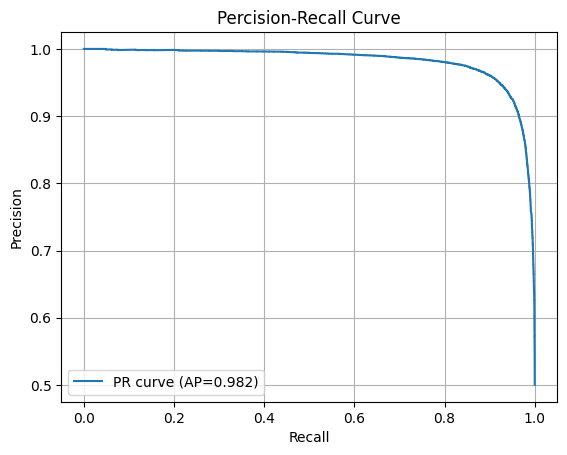


Top SI-indicative features (+):
suicide                        7.2366
suicidal                       6.7031
kill                           5.3676
mei                            4.0797
killing                        3.7523
iti                            3.5861
helpi                          3.4358
anymorei                       3.3856
lifei                          3.2041
pill                           3.1252
diei                           3.1138
die                            3.1028
end                            3.0816
anymore                        3.0747
myselfi                        3.0483
life                           2.9824
living                         2.7096
donei                          2.6839
overdose                       2.6272
upi                            2.5212
ending                         2.5104
retarded                       2.4971
alive                          2.4907
rope                           2.4687
attempt                        2.4604

Top non-SI-indic

In [9]:
### Baseline model training & evaluation pipeline.
# Load splits
train = pd.read_csv('train_set.csv')
val = pd.read_csv('val_set.csv')
test = pd.read_csv('test_set.csv')

X_train, y_train = train['text'].astype(str), train['label'].astype(int)
X_val, y_val = val['text'].astype(str), val['label'].astype(int)
X_test, y_test = test['text'].astype(str), test['label'].astype(int)
# Merge Train + Val for retaining final best model.
X_trval = pd.concat([X_train, X_val,], axis=0)
y_trval = pd.concat([y_train, y_val,], axis=0)
# TF-IDF Vectorizer, converting text into numerical vectors.
tfidf = TfidfVectorizer(
    ngram_range=(1,2), # Bigrams + unigrams for richer terms.
    max_features=200000, # Limits vocabulary to 200k most frequent terms.
    min_df=5, # Ignores words that appear in fewer than 5 docs (min_df=5).
    max_df=0.8, # Ignores words that appear in >80% of docs (max_df=0.8).
    sublinear_tf=True, # uses log-scaling for term frequencies.
    stop_words='english' # Removes English stopwords.
)
# Logistic Regression
logreg = LogisticRegression(
    solver='liblinear',
    class_weight=None,
    max_iter=200
)
# Both wrapped in pipelines so preprcessing + model run seamlessly.
pipe_lr = Pipeline([
    ('tfidf', tfidf),
    ('clf', logreg)
])
# Linear SVM
svm = LinearSVC()
# Both wrapped in pipelines so preprcessing + model run seamlessly.
pipe_svm = Pipeline([
    ('tfidf', tfidf),
    ('clf', svm)
])
# Grid search will try different combinations of ngram range, document frequnecy cutoff and regularization strength.
param_grid_lr = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'clf__C':[0.5, 1.0, 2.0, 3.0]
}

param_grid_svm = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'clf__C': [0.5, 1.0, 2.0, 3.0]
}
# Grid search training.
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, scoring='f1', cv=3, n_jobs=-1, verbose=1)
gs_lr.fit(X_train, y_train)
print("Best LR params:", gs_lr.best_params_)

gs_svm = GridSearchCV(pipe_svm, param_grid_svm, scoring='f1', cv=3, n_jobs=-1, verbose=1)
gs_svm.fit(X_train, y_train)
print("Best SVM params:", gs_svm.best_params_)

# Evaluation function.
def evaluate(model, X, y, name="Model"):
    y_pred = model.predict(X)
    print(f"\n==== {name} ====")
    print(classification_report(y, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))
# Validation Evaluation, compares best LR and SVM on validation set.
evaluate(gs_lr.best_estimator_, X_val, y_val, name="Logreg (val)")
evaluate(gs_svm.best_estimator_, X_val, y_val, name="Linear SVM (val)")
# Choose best model, based on higher cross-val F1.
best_model = gs_lr.best_estimator_ if gs_lr.best_score_ >= gs_svm.best_score_ else gs_svm.best_estimator_
best_name = "Logreg" if gs_lr.best_score_ >= gs_svm.best_score_ else "Linear SVM"

# Retrains best model on combined training + validation data.
best_model.fit(X_trval, y_trval)
evaluate(best_model, X_test, y_test, name=f"{best_name} (test)")
# Computes Precision-Recall AUC and ROC-AUC.
if best_name == "Logreg":
    y_proba = best_model.predict_proba(X_test)[:,1]
    pr_auc = average_precision_score(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"PR-AUC: {pr_auc:.4f} | ROC-AUC: {roc_auc:.4f}")
else:
    from sklearn.metrics import precision_recall_curve, average_precision_score
    scores = best_model.decision_function(X_test)
    percision, recall, thresholds = precision_recall_curve(y_test, scores)
    pr_auc = average_precision_score(y_test, scores)
    print(f"PR-AUC (decision scores): {pr_auc:.4f}")

    plt.figure()
    plt.plot(recall, percision, label=f"PR curve (AP={pr_auc:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Percision-Recall Curve")
    plt.legend(); plt.grid(True); plt.show()
# Gets top negative and positive features.
def show_top_features(pipeline, top_n=20):
    vec = pipeline.named_steps['tfidf']
    clf = pipeline.named_steps['clf']
    feature_names = vec.get_feature_names_out()

    if hasattr(clf, 'coef_'):
        if isinstance(clf, LinearSVC):
          coefs = clf.coef_[0]
        else:
          coefs = clf.coef_[0]

        top_pos = np.argsort(coefs)[-top_n:][::-1]
        top_neg = np.argsort(coefs)[:top_n]

        print("\nTop SI-indicative features (+):")
        for i in top_pos:
            feature = str(feature_names[i])
            coef = float(coefs[i])
            print(f"{feature:<30} {coef:.4f}")

        print("\nTop non-SI-indicative features (-):")
        for i in top_neg:
            feature = str(feature_names[i])
            coef = float(coefs[i])
            print(f"{feature:<30} {coef:.4f}")
    else:
      print("Top features not available for this classifier.")

show_top_features(best_model, top_n=25)

In [11]:
### Post-evaluation diagnostic tool.

# Loading test data and predictins.
X_test = test['text'].astype(str) # Input texts from the test set.
y_test = test['label'].astype(int) # True labels.

y_pred = best_model.predict(X_test) # Model's predicted labels.
scores = best_model.decision_function(X_test) # Raw decision score from LinearSVC.
# Confusion matrix & metrics
cm = confusion_matrix(y_test, y_pred, labels=[0, 1]) # Counts of true negative, false positve, false negative, true positives.
tn, fp, fn, tp = cm.ravel() # For clear matrics values.
print(cm, tn, fp, fn, tp)

print(classification_report(y_test, y_pred, digits=4))

# Build analysis DataFrame
analysis = test.copy()
analysis['pred'] = y_pred # Predicted label.
analysis['score'] = scores # Model's decision score.
analysis['correct'] = (analysis['label'] == analysis['pred']) # Wether prediction matches the true label.
analysis['error_type'] = np.where((analysis['label']==1) & (analysis['pred']==0), 'FN',
                         np.where((analysis['label']==0) & (analysis['pred']==1), 'FP', 'OK')) # Categorise each predition.


[[21802  1383]
 [ 1509 21687]] 21802 1383 1509 21687
              precision    recall  f1-score   support

           0     0.9353    0.9403    0.9378     23185
           1     0.9401    0.9349    0.9375     23196

    accuracy                         0.9376     46381
   macro avg     0.9377    0.9376    0.9376     46381
weighted avg     0.9377    0.9376    0.9376     46381



In [12]:
### Bucketed performance analysis

# Adding text length, if missing.
if 'text_length' not in analysis.columns:
    analysis['text_length'] = analysis['text'].str.len()
# Bucket posts by length.
bins = [0, 100, 500, 1500, np.inf]
labels = ['Very Short', 'Short', 'Medium', 'Long']
analysis['length_bucket'] = pd.cut(analysis['text_length'], bins=bins, labels=labels, right=True)
# Defining per-bucket metric function.
def slice_metrics(df):
    m = []
    for b in labels:
        sub = df[df['length_bucket']==b] # Iterates through each length bucket.
        if len(sub)==0: # Filters the dataset to only posts int that bucket(sub).
            continue
        p, r, f1, _ = precision_recall_fscore_support(sub['label'], sub['pred'], average='binary', pos_label=1, zero_division=0) # Computes precision, recall, F1 for suicidal class (1) in that slice.
        m.append({'bucket': b, 'n': len(sub), 'percision_SI': p, 'recall_SI': r, 'f1_SI': f1}) # And stores the results along with sample count(n).
    return pd.DataFrame(m)

bucket_metrics = slice_metrics(analysis)
print(bucket_metrics)

       bucket      n  percision_SI  recall_SI     f1_SI
0  Very Short  15522      0.863119   0.772414  0.815251
1       Short  20746      0.938875   0.942316  0.940592
2      Medium  10099      0.965396   0.982394  0.973821
3        Long     14      0.000000   0.000000  0.000000


In [16]:
### When explicit suicide-related keywords are present in the text vs. when they are not.
si_keywords = [
    'suicide','suicidal','kill myself','end my life','die','don\'t want to live',
    'better off dead','overdose','rope','goodbye note','take my own life','ending it',
    'no reason to live','self harm','cut myself','jump off'
]

def has_si_keyword(text):
    t = text.lower()
    return any(k in t for k in si_keywords)

analysis['has_si_kw'] = analysis['text'].apply(has_si_keyword)

kw_grp = analysis.groupby('has_si_kw')['error_type'].value_counts(normalize=True).unstack(fill_value=0)
print(kw_grp)

def recall_slice(df):
  sub = df[df['label']==1]
  return recall_score(sub['label'], sub['pred'])

recall_with_kw = recall_slice(analysis[analysis['has_si_kw']==True])
recall_without_kw = recall_slice(analysis[analysis['has_si_kw']==False])
print({'recall_with_kw': recall_with_kw, 'recall_without_kw': recall_without_kw})

error_type        FN       FP        OK
has_si_kw                              
False       0.039131  0.03064  0.930230
True        0.015041  0.02764  0.957319
{'recall_with_kw': 0.9834258937868795, 'recall_without_kw': 0.8870801919122687}


In [20]:
### The most critical errors.
top_fn = analysis[(analysis['error_type']=='FN')].sort_values('score', ascending=True).head(100)
top_fp = analysis[(analysis['error_type']=='FP')].sort_values('score', ascending=False).head(100)

cols_to_view = ['text_length', 'length_bucket', 'score', 'label', 'pred']
display(top_fn[cols_to_view + ['text']].head(10))
display(top_fp[cols_to_view + ['text']].head(10))

,text_length,length_bucket,score,label,pred,text
35517,138,Short,-2.076547,1,0,wan diehey guy kinda like girl friend girl lik...
37143,467,Short,-1.913515,1,0,made constantly updated document thats basical...
39737,131,Short,-1.761409,1,0,tfw crush asleep hour nowthats one thing going...
6480,22,Very Short,-1.723207,1,0,ittoo much idk excited
38148,44,Very Short,-1.721364,1,0,usa state gunsi travel covid lockdown please
44020,9,Very Short,-1.684928,1,0,done test
1173,171,Short,-1.606891,1,0,banned think banned although could wrong notif...
30767,18,Very Short,-1.565861,1,0,lol byebottom text
5404,33,Very Short,-1.554991,1,0,going killm yselfjust kidding lol
7924,172,Short,-1.532958,1,0,get good somethinglegit taken art class year r...


,text_length,length_bucket,score,label,pred,text
607,1130,Medium,2.749363,0,1,alive hate alive could bed could happy please ...
29519,1102,Medium,2.658765,0,1,even know tried keeping thought want burden pe...
43308,416,Short,2.564781,0,1,feel like life come end always suicidal lately...
29668,410,Short,2.367149,0,1,want end life want end care anymore funny cons...
11735,890,Medium,2.354517,0,1,want die want stop pain suicide never stop pai...
20486,14,Very Short,2.277388,0,1,must die goodㅤ
32874,172,Short,2.213327,0,1,die please give way die please kill let die ca...
40747,98,Very Short,2.058719,0,1,suicidal birthday december plannjng end life d...
31621,371,Short,2.035386,0,1,wan kill km km km km km km km fucking life goi...
41700,592,Medium,2.034207,0,1,tired mentally know nothing make happy anymore...
